In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

In [58]:
def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df



In [59]:
def train_model(df):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.fit(df)
    return model



In [60]:
def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future



In [61]:
def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse



In [55]:
def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    #ax.plot(forecast_historical['ds'], forecast_historical['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders (Train)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    #ax.plot(forecast_future['ds'], forecast_future['yhat'], marker='o', linestyle='--', label='Predicted Bad Orders (Future)')
    #ax.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='gray', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [41]:
# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ds                  51 non-null     datetime64[ns]
 1   Fleets_in_Service   51 non-null     float64       
 2   Bad_orders          51 non-null     int64         
 3   Bad_orders_Monthly  51 non-null     int64         
 4   y                   51 non-null     int64         
 5   month               51 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 2.3 KB


In [43]:
df.head()

,ds,Fleets_in_Service,Bad_orders,Bad_orders_Monthly,y,month
0,2022-10-01,46088.262272,57,1710,1344,10
1,2022-11-01,46031.636754,79,2370,1177,11
2,2022-12-01,42783.989750,84,2520,1399,12
3,2023-01-01,41647.896564,75,2250,1386,1
4,2023-02-01,41701.307188,75,2250,1329,2


In [44]:
df.dtypes

ds                    datetime64[ns]
Fleets_in_Service            float64
Bad_orders                     int64
Bad_orders_Monthly             int64
y                              int64
month                          int32
dtype: object

In [45]:
df['Fleets_in_Service'] =  df['Fleets_in_Service'].astype(int)

In [46]:
# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)


14:13:12 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
test_df.head()

,ds,Fleets_in_Service,Bad_orders,Bad_orders_Monthly,y,month
39,2026-01-01,42359,64,1920,1116,1
40,2026-02-01,40530,70,2100,1197,2
41,2026-03-01,41267,83,2490,1023,3
42,2026-04-01,42658,65,1950,878,4
43,2026-05-01,43504,56,1680,953,5


In [50]:
# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)  # No future periods needed for historical

MAE: 202.47259897139847
MSE: 68755.51554020014
RMSE: 262.2127295540782


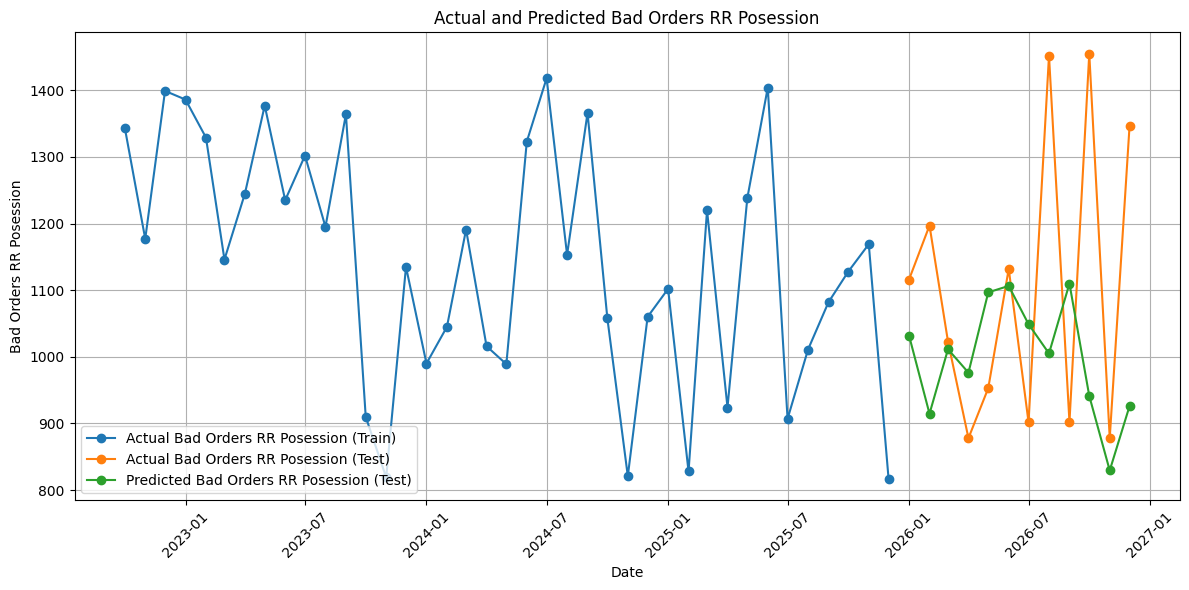

           ds         yhat  yhat_lower   yhat_upper
0  2026-01-01  1031.977388  887.623729  1177.171895
1  2026-02-01   914.622247  747.152639  1065.713558
2  2026-03-01  1011.393892  867.257919  1170.711064
3  2026-04-01   976.251550  834.537975  1134.192933
4  2026-05-01  1096.780369  939.085950  1248.706508
5  2026-06-01  1106.399625  955.422823  1251.248936
6  2026-07-01  1049.062653  891.516827  1196.504901
7  2026-08-01  1005.083929  863.008102  1153.140847
8  2026-09-01  1109.994523  971.788179  1262.798951
9  2026-10-01   941.355952  800.348214  1091.245443
10 2026-11-01   829.525116  677.592479   975.311671
11 2026-12-01   926.059758  771.424844  1072.950247


In [56]:
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds','yhat', 'yhat_lower', 'yhat_upper']])

Analysis of Results
MAE of 202.47: This suggests that, on average, 
the model's predictions are off by about 202.47 bad orders RR Possession. 
For your application, this may or may not be acceptable depending on the typical scale of bad orders RR Possession.

MSE of 68755.52: This high value indicates that there are some large errors in the model's predictions. 
Squaring the errors exaggerates the effect of larger errors, leading to a higher value.

RMSE of 262.21: This metric, being in the same units as the data, is more interpretable. 
It indicates that the typical deviation from the actual values is around 262.21 bad orders.

C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

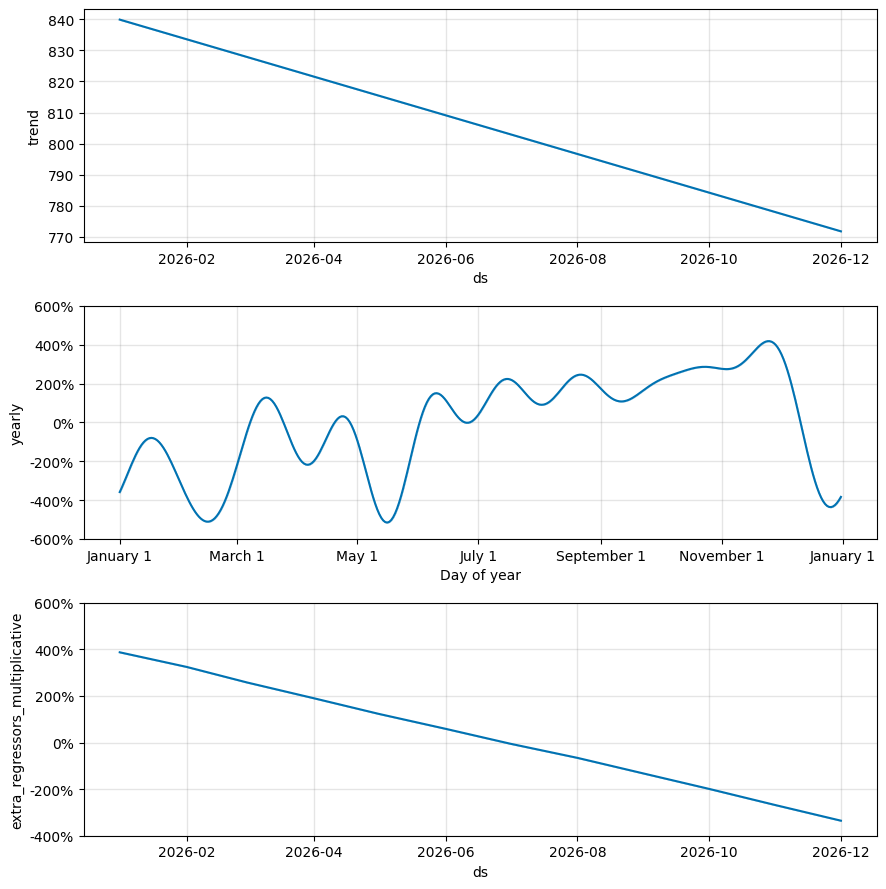

In [53]:
fig = model.plot_components(forecast_test)
plt.show()

Trend Component:If the trend line is upward, it suggests that the number of Bad_orders RR Posession is generally increasing over time.
If downward, it suggests a decrease.

Yearly Seasonality Component:Peaks in specific months suggest higher Bad_orders RR Posession during those months.
Troughs indicate lower Bad_orders RR Posession in other months.

Regressors:Shows how changes in Fleets_in_Service influence Bad_orders RR Posession.
If the plot for Fleets_in_Service shows an upward slope, it means that as the fleet size increases, the number of Bad_orders also increases.